<a href="https://colab.research.google.com/github/SilahicAmil/NLP/blob/main/Multi_Label_Sentiment_Analysis_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Sentiment Analysis Practice

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

# keras
import keras
from keras.layers import Embedding, TextVectorization
from keras.metrics import categorical_accuracy


# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Data

In [4]:
full_data = pd.read_csv("/content/drive/MyDrive/Random_Sentiment_Analysis/data.csv")
full_data.head()

,Unnamed: 0,Sentence,Sentiment
0,0,The GeoSolutions technology will leverage Bene...,positive
1,1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,2,"For the last quarter of 2010 , Componenta 's n...",positive
3,3,According to the Finnish-Russian Chamber of Co...,neutral
4,4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
full_data.Sentiment.value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

# Shuffle Data

In [10]:
shuffled_full_data = full_data.sample(frac=1, random_state=69)
shuffled_full_data.head()

,Unnamed: 0,Sentence,Sentiment
1776,1776,"The port facilities ' throughput is 250,000 TE...",neutral
1210,1210,"s business sectors are building construction ,...",neutral
2528,2528,"The customer is then forwarded to the site , a...",neutral
1295,1295,"In July-September 2008 , YIT 's net sales incr...",positive
814,814,Productional situation has now improved .,positive


# Train/Test/Val Sets

In [11]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(shuffled_full_data["Sentence"].to_numpy(),
                                                                              shuffled_full_data["Sentiment"].to_numpy(),
                                                                              test_size=0.2,
                                                                              random_state=69)

In [12]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences,
                                                                            train_labels,
                                                                            test_size=0.15,
                                                                            random_state=69)

# One Hot Encode aka Numeric Labels

In [13]:
one_hot = OneHotEncoder(sparse=False)

train_labels_onehot = one_hot.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = one_hot.fit_transform(test_labels.reshape(-1, 1))
val_labels_onehot = one_hot.fit_transform(val_labels.reshape(-1, 1))

train_labels_onehot[:5]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

# Label Encoding 

In [14]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.fit_transform(test_labels)
val_labels_encoded = label_encoder.fit_transform(val_labels)

train_labels_encoded[:5]

array([2, 0, 2, 0, 1])

In [16]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(3, array(['negative', 'neutral', 'positive'], dtype=object))

# Prep Vectorization

In [21]:
sent_lens = [len(i.split()) for i in train_sentences]

In [20]:
round(sum([len(i.split()) for i in train_sentences]))/len(train_sentences)


21.08710976837865

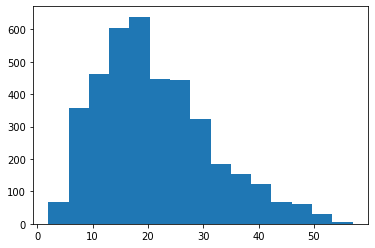

In [24]:
plt.hist(sent_lens, bins=15);

In [26]:
MAX_SENT_LEN  = int(np.percentile(sent_lens, 98))
MAX_SENT_LEN

46

# Vectorization

In [27]:
MAX_VOCAB = 12_000
txt_vect = TextVectorization(max_tokens=MAX_VOCAB,
                             output_mode="int",
                             pad_to_max_tokens=True,
                             output_sequence_length=MAX_SENT_LEN)

In [28]:
txt_vect.adapt(train_sentences)

# Functions (compile, fit and calc_results)

In [29]:
def compile_model(model):
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  
def fit_model(model, epochs):
  model.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=epochs,
            validation_data=val_dataset,
            validation_steps=int(0.1*len(val_dataset)))

In [30]:
# Calc results

def calc_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  results = {"Accuracy": model_accuracy,
             "Precision": model_accuracy,
             "Recall": model_recall,
             "F1": model_f1}

  return results

# Performant Datasets (tf.data API)

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Conv1D Model

In [34]:
Embedding = keras.layers.Embedding(input_dim=MAX_VOCAB,
                                      output_dim=128,
                                      input_length=MAX_SENT_LEN)

In [35]:
tf.random.set_seed(69)

inputs = keras.layers.Input(shape=(1, ), dtype="string")

vectorizer = txt_vect(inputs)

embed = Embedding(vectorizer)

# Conv1D model
x = keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embed)

# Pooling Layer
x = keras.layers.GlobalAveragePooling1D()(x)

# Dense Output
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

# Model creation
model_0 = tf.keras.Model(inputs, outputs, name="Baseline")

In [36]:
model_0.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 46)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 46, 128)           1536000   
                                                                 
 conv1d (Conv1D)             (None, 46, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)                 195

In [37]:
compile_model(model_0)

In [38]:
hist_0 = fit_model(model_0, 10)

Epoch 1/10
12/12 [==============================] - 4s 144ms/step - loss: 1.0451 - accuracy: 0.5521 - val_loss: 1.0199 - val_accuracy: 0.5156
Epoch 2/10
12/12 [==============================] - 1s 83ms/step - loss: 0.9643 - accuracy: 0.5833 - val_loss: 1.0259 - val_accuracy: 0.5156
Epoch 3/10
12/12 [==============================] - 1s 77ms/step - loss: 0.9882 - accuracy: 0.5391 - val_loss: 0.9959 - val_accuracy: 0.5156
Epoch 4/10
12/12 [==============================] - 1s 72ms/step - loss: 1.0233 - accuracy: 0.5104 - val_loss: 0.9851 - val_accuracy: 0.5156
Epoch 5/10
12/12 [==============================] - 1s 61ms/step - loss: 0.9769 - accuracy: 0.5156 - val_loss: 0.9730 - val_accuracy: 0.5156
Epoch 6/10
12/12 [==============================] - 1s 63ms/step - loss: 0.9843 - accuracy: 0.4922 - val_loss: 0.9577 - val_accuracy: 0.5156
Epoch 7/10
12/12 [==============================] - 1s 57ms/step - loss: 0.9622 - accuracy: 0.5417 - val_loss: 0.9406 - val_accuracy: 0.5156
Epoch 8/10
1

In [39]:
# Making pred probs
model_0_pred_probs = model_0.predict(val_dataset)
model_0_pred_probs[:2]

array([[0.10154901, 0.7098753 , 0.18857577],
       [0.12585631, 0.62114555, 0.25299814]], dtype=float32)

In [40]:
# Make preds
model_0_preds = tf.argmax(model_0_pred_probs, axis=1)
model_0_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 1, 1, 1])>

In [41]:
baseline_results = calc_results(val_labels_encoded,
                                model_0_preds)
baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 64.05135520684736,
 'F1': 0.5806064053321796,
 'Precision': 64.05135520684736,
 'Recall': 0.6405135520684736}